# Evaluating the Model

This notebook follows training the model and will give a the final training and test error for the model. To download the trained model, follow the instructions in [README.md](README.md).

In [3]:
# Imports
import random
import tensorflow as tf
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline
import os
import tensorboard as tb
from tensorboard.backend.event_processing import event_accumulator

In [24]:
experiment_id = "dTD0vaI3SdyRZYI4WLHRbg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
output  = df.pivot(index="run", columns="tag", values="value")

In [25]:
output

tag,DetectionBoxes_Precision/mAP,DetectionBoxes_Precision/mAP (large),DetectionBoxes_Precision/mAP (medium),DetectionBoxes_Precision/mAP (small),DetectionBoxes_Precision/mAP@.50IOU,DetectionBoxes_Precision/mAP@.75IOU,DetectionBoxes_Recall/AR@1,DetectionBoxes_Recall/AR@10,DetectionBoxes_Recall/AR@100,DetectionBoxes_Recall/AR@100 (large),DetectionBoxes_Recall/AR@100 (medium),DetectionBoxes_Recall/AR@100 (small),Loss/classification_loss,Loss/localization_loss,Loss/regularization_loss,Loss/total_loss
run,,,,,,,,,,,,,,,,
eval,0.577580,0.804416,0.420162,0.004719,0.823290,0.649656,0.369214,0.635027,0.658216,0.844016,0.557507,0.157143,0.181020,0.003023,0.037377,0.221419
test,0.577580,0.804416,0.420162,0.004719,0.823290,0.649656,0.369214,0.635027,0.658216,0.844016,0.557507,0.157143,0.223413,0.003314,0.037377,0.264104
training,0.600287,0.818538,0.414392,0.005160,0.840275,0.676805,0.393724,0.652730,0.672312,0.853080,0.558387,0.147729,0.181020,0.003023,0.037377,0.221419


In [3]:
def import_data(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        f = os.path.join(path, filename)
        if os.path.isfile(f):
            if f[-3:] == "jpg":
                images.append(f)
            else:
                labels.append(f)
    return (images, labels)

In [4]:
# Replace if you placed the model or labels in a nonstandard location
PATH_TO_SAVED_MODEL = "./training-workspace/exported-models/my_model/saved_model"
TEST_DATA = import_data("./images/test")
TRAIN_DATA = import_data("./images/train")
category_index = {0: "Bicycle"}

In [5]:
print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 31.28362798690796 seconds


In [6]:
IMAGE_PATHS = TEST_DATA[0]

Running inference for ./images/test\005801.jpg... Done
Running inference for ./images/test\009000.jpg... Done
Running inference for ./images/test\012917.jpg... Done
Running inference for ./images/test\007297.jpg... Done
Running inference for ./images/test\008593.jpg... Done
Running inference for ./images/test\000790.jpg... Done
Running inference for ./images/test\005365.jpg... Done
Running inference for ./images/test\012073.jpg... Done
Running inference for ./images/test\001942.jpg... Done
Running inference for ./images/test\005942.jpg... Done


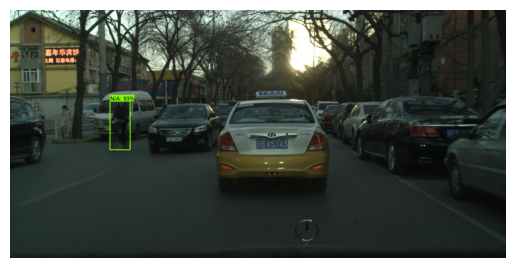

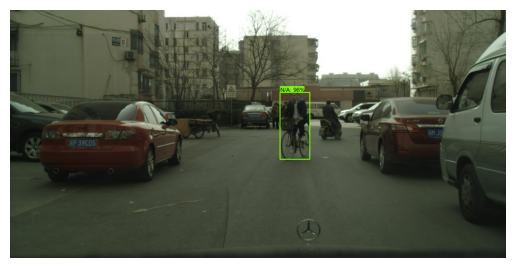

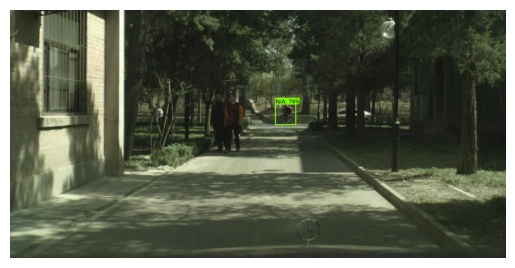

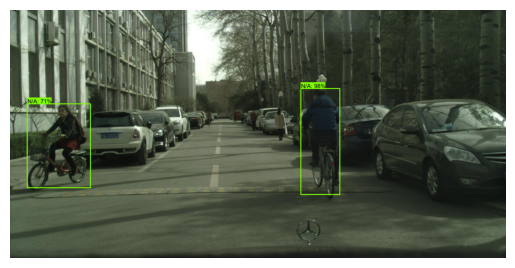

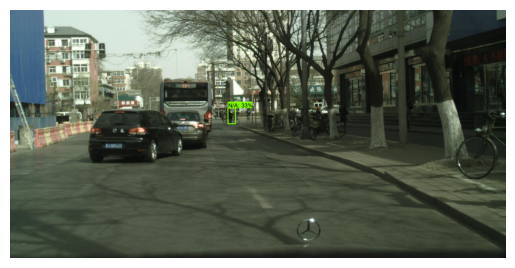

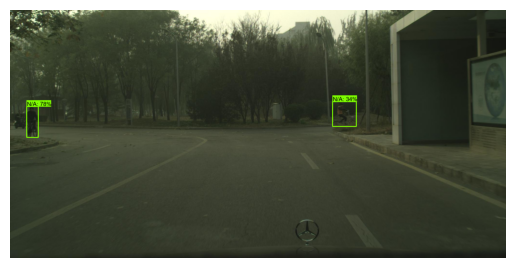

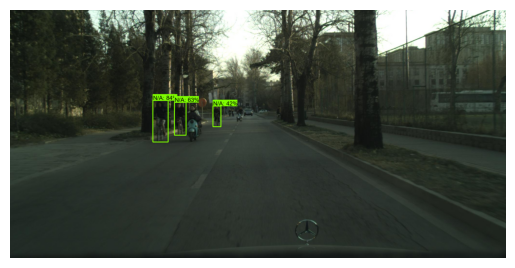

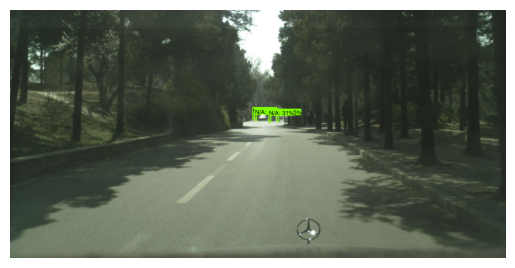

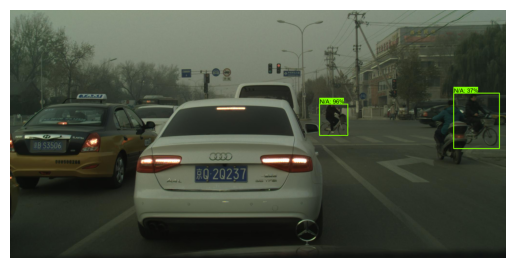

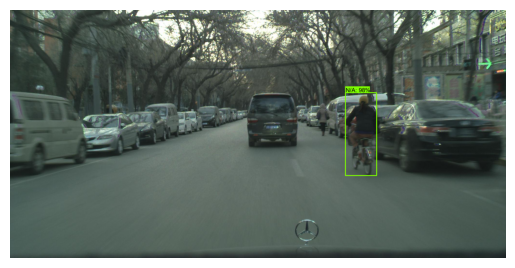

In [15]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in random.choices(IMAGE_PATHS, k=10):

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.axis("off")
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()